# **Project: Research Paper Answer Bot**

## Installing all the dependencies

In [1]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1

# takes 2 - 5 mins to install on Colab
!pip install "unstructured[all-docs]==0.14.0"

!pip install jq==1.7.0
!pip install pypdf==4.2.0
!pip install pymupdf==1.24.4

!pip install langchain-text-splitters==0.2.0
!pip install tiktoken==0.7.0
!pip install spacy
!pip install sentence-transformers==2.7.0

!pip install langchain-huggingface==0.0.1

!pip install langchain-chroma

  Using cached pypdf-4.2.0-py3-none-any.whl.metadata (7.4 kB)
Using cached pypdf-4.2.0-py3-none-any.whl (290 kB)
  Attempting uninstall: pypdf
    Found existing installation: pypdf 5.0.1
    Uninstalling pypdf-5.0.1:
      Successfully uninstalled pypdf-5.0.1
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.2.4
    Uninstalling langchain-text-splitters-0.2.4:
      Successfully uninstalled langchain-text-splitters-0.2.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: tiktoken
    Found existing installation: tiktoken 0.8.0
    Uninstalling tiktoken-0.8.0:
      Successfully uninstalled tiktoken-0.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyprojec

## Setup Key and Environmental Variables

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


In [3]:
HUGGINGFACEHUB_API_TOKEN = getpass('Enter HuggingFace Auth Token Key: ')

Enter HuggingFace Auth Token Key: ··········


In [4]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


In [5]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['HUGGINGFACEHUB_API_TOKEN'] = HUGGINGFACEHUB_API_TOKEN
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## Load Connection to LLM

In [6]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)

## **Implementing Compulsary Goals**

### Load the Files and setup vector database

In [7]:
from langchain_community.document_loaders import PyMuPDFLoader

# Define a dictionary to map file extensions to their respective loaders
loaders = {
    '.pdf': (PyMuPDFLoader, {}),
    # '.docx': (UnstructuredWordDocumentLoader, {'strategy': 'fast',
    #                                           'chunking_strategy' : 'by_title',
    #                                           'max_characters' : 3000, # max limit of a document chunk
    #                                           'new_after_n_chars' : 2500, # preferred document chunk size
    #                                           'mode' : 'elements'
    #                                           })
}

In [8]:
from langchain_community.document_loaders import DirectoryLoader

# Define a function to create a DirectoryLoader for a specific file type
def create_directory_loader(file_type, directory_path):
    return DirectoryLoader(
        path=directory_path,
        glob=f"**/*{file_type}",
        loader_cls=loaders[file_type][0],
        loader_kwargs=loaders[file_type][1],
        show_progress=True
    )

# Create DirectoryLoader instances for each file type
pdf_loader = create_directory_loader('.pdf', '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data')
# docx_loader = create_directory_loader('.docx', './')

# Load the files
pdf_documents = pdf_loader.load()
# docx_documents = docx_loader.load()

100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


In [9]:
len(pdf_documents)

95

In [10]:
pdf_documents[18]

Document(metadata={'source': '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data/mistral_paper.pdf', 'file_path': '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data/mistral_paper.pdf', 'page': 3, 'total_pages': 6, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'PDFium', 'producer': 'PDFium', 'creationDate': 'D:20240719225025', 'modDate': '', 'trapped': ''}, page_content='Figure 4: Performance of Mistral 7B and different Llama models on a wide range of benchmarks. All\nmodels were re-evaluated on all metrics with our evaluation pipeline for accurate comparison. Mistral 7B\nsignificantly outperforms Llama 2 7B and Llama 2 13B on all benchmarks. It is also vastly superior to Llama 1\n34B in mathematics, code generation, and reasoning benchmarks.\nModel\nModality MMLU HellaSwag WinoG PIQA\nArc-e\nArc-c\nNQ\nTriviaQA HumanEval MBPP MATH GSM8K\nLLaMA 2 7B\nPretrained 44.4%\n77.1%\n69.5% 77.9% 68.7% 43.2% 24.7%\

In [11]:
type(pdf_documents)

list

In [12]:
docs = pdf_documents

**Create LangChain Documents**

In [13]:
from langchain.docstore.document import Document

docs = [Document(page_content=doc.page_content,
                 metadata=doc.metadata) for doc in docs]

In [14]:
docs[:3]

[Document(metadata={'source': '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data/attention_paper.pdf', 'file_path': '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data/attention_paper.pdf', 'page': 0, 'total_pages': 15, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.25', 'creationDate': 'D:20240410211143Z', 'modDate': 'D:20240410211143Z', 'trapped': ''}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗†\nUniversity of Toronto\naidan@c

In [15]:
len(docs)

95

**Split larger documents into smaller chunks**

In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)

In [17]:
chunked_docs[:3]

[Document(metadata={'source': '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data/attention_paper.pdf', 'file_path': '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data/attention_paper.pdf', 'page': 0, 'total_pages': 15, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.25', 'creationDate': 'D:20240410211143Z', 'modDate': 'D:20240410211143Z', 'trapped': ''}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗†\nUniversity of Toronto\naidan@c

In [18]:
len(chunked_docs)

204

**Experiment with different embedding models**

**openAI embeddings**

In [19]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

In [20]:
# Extract the text content from each document
chunked_docs_texts = [chunked_docs.page_content for chunked_docs in chunked_docs]

# Pass the extracted text content to the embedding model
embeddings = openai_embed_model.embed_documents(chunked_docs_texts)

In [21]:
len(embeddings)

204

In [22]:
len(embeddings[10])

1536

In [23]:
print(embeddings[10])

[-0.004056982696136587, 0.018843078986182878, 0.06098899990440804, -0.010734951123807507, 0.008615980856290957, 0.020279075950785132, 0.03558469936322005, 0.020722717047147437, -0.03647198155594465, 0.04964112490513732, 0.00701653724550174, -0.029840713367456174, -0.02365308441268485, 0.0017045164713973087, 0.025614446029573534, -0.03890033438878686, 0.04314995184626072, -0.0016125777038133126, 0.009316466748898668, 0.013834603131090976, -0.0349776111550095, -0.030307704583409697, 0.005954132881133275, 0.0047020139173602985, 0.053377050907475215, -0.014149821363669287, -0.01173898205184307, 0.038853637874894716, 0.040534801781979046, -0.03299290314381989, 0.011394576169775732, -0.029280323535782915, -0.05856064707156583, -0.059261135758141265, -0.003697983454986024, 0.014371642843173013, -0.01267880108232535, 0.03623848781061304, -0.060942303390515894, 0.04392048716631952, 0.025450998917725284, -0.020652668551018924, -0.056178994477906065, 0.012655450962734129, 0.01123696658782529, 2.2

**Open Source Embedding Models on HuggingFace**


In [24]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

# check out model details here: https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1
model_name = "mixedbread-ai/mxbai-embed-large-v1"

hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/114k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [25]:
embeddings = hf_embeddings.embed_documents(chunked_docs_texts)

In [26]:
len(embeddings)

204

In [27]:
len(embeddings[0])

1024

In [28]:
print(embeddings[0])

[0.2757548987865448, 0.3845578134059906, -0.4568205773830414, -0.2763338088989258, 0.029887191951274872, -0.02544581890106201, -0.03740381821990013, -0.37605324387550354, -0.4465924799442291, 0.5872412323951721, 0.7079259157180786, 0.10372361540794373, -0.04959478974342346, -1.0523818731307983, -0.377909779548645, -0.5055117607116699, -0.0463903471827507, -0.5088703036308289, -0.7846989035606384, -0.46400272846221924, 0.19471679627895355, -0.23496495187282562, -0.9955841898918152, 0.05174575373530388, -0.25899073481559753, 0.24758705496788025, 0.6653371453285217, 0.17045192420482635, 1.615617036819458, 0.6573950052261353, 0.6480590105056763, -0.37707313895225525, 0.6688839197158813, -0.28713661432266235, -0.0995987206697464, -0.6994351148605347, 0.4054013192653656, -0.04849502444267273, -0.4991722106933594, -0.22345030307769775, -0.07443972676992416, -0.411498099565506, 0.4122215211391449, -0.6318870186805725, -1.4490340948104858, 0.07992646843194962, 0.5553582906723022, -0.70259267091

**Create a Vector DB and persist on disk**


In [29]:
!rm -rf "/content/research_papers_db" #replace path to db

In [30]:
from langchain_chroma import Chroma

# create vector DB of docs and embeddings - takes < 30s on Colab
chroma_db = Chroma.from_documents(documents=chunked_docs,
                                  collection_name='research_papers_chroma_db',
                                  embedding=openai_embed_model,
                                  # need to set the distance function to cosine else it uses euclidean by default
                                  # check https://docs.trychroma.com/guides#changing-the-distance-function
                                  collection_metadata={"hnsw:space": "cosine"},
                                  persist_directory="/content/research_papers_db")

**Load Vector DB from disk**



In [68]:
# load from disk
research_papers_chroma_db = Chroma(persist_directory="/content/research_papers_db",
                   collection_name='research_papers_chroma_db',
                   embedding_function=openai_embed_model)

In [69]:
research_papers_chroma_db

### Experiment with different retrieval stratagies

**ContexualCompressionretriever**

In [70]:
from langchain.retrievers.document_compressors import LLMChainFilter
from langchain.retrievers import ContextualCompressionRetriever

In [71]:
# simple cosine distance based retriever
similarity_retriever = research_papers_chroma_db.as_retriever(search_type="similarity",
                                              search_kwargs={"k": 3})

#  decides which of the initially retrieved documents to filter out and which ones to return
_filter = LLMChainFilter.from_llm(llm=chatgpt)

# retrieves the documents similar to query and then applies the filter
compression_retriever = ContextualCompressionRetriever(
    base_compressor=_filter, base_retriever=similarity_retriever
)

In [72]:
query = "What attention mechanisms were used in the Attention paper?"
docs = compression_retriever.invoke(query)
docs

[Document(metadata={'author': '', 'creationDate': 'D:20240410211143Z', 'creator': 'LaTeX with hyperref', 'file_path': '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data/attention_paper.pdf', 'format': 'PDF 1.5', 'keywords': '', 'modDate': 'D:20240410211143Z', 'page': 13, 'producer': 'pdfTeX-1.40.25', 'source': '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data/attention_paper.pdf', 'subject': '', 'title': '', 'total_pages': 15, 'trapped': ''}, page_content='Input-Input Layer5\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pad>\nInput-Input Layer5\nThe\nLaw\nwill\nnever\nbe\nperfect\n,\nbut\nits\napplication\nshould\nbe\njust\n-\nthis\nis\nwhat\nwe\nare\nmissing\n,\nin\nmy\nopinion\n.\n<EOS>\n<pa

**MultiQueryRetriever**

In [73]:
from langchain.retrievers.multi_query import MultiQueryRetriever
# Set logging for the queries
import logging

similarity_retriever = research_papers_chroma_db.as_retriever(search_type="similarity",
                                              search_kwargs={"k": 3})

mq_retriever = MultiQueryRetriever.from_llm(
    retriever=similarity_retriever, llm=chatgpt
)

logging.basicConfig()
# so we can see what queries are generated by the LLM
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [74]:
query = "What attention mechanisms were used in the Attention paper?"
docs = mq_retriever.invoke(query)
docs

INFO:langchain.retrievers.multi_query:Generated queries: ['What types of attention mechanisms are discussed in the original Attention paper?  ', 'Which attention mechanisms are introduced in the foundational Attention paper?  ', 'Can you list the attention mechanisms that were proposed in the Attention paper?']


[Document(metadata={'author': '', 'creationDate': 'D:20240410211143Z', 'creator': 'LaTeX with hyperref', 'file_path': '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data/attention_paper.pdf', 'format': 'PDF 1.5', 'keywords': '', 'modDate': 'D:20240410211143Z', 'page': 12, 'producer': 'pdfTeX-1.40.25', 'source': '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data/attention_paper.pdf', 'subject': '', 'title': '', 'total_pages': 15, 'trapped': ''}, page_content='Attention Visualizations\nInput-Input Layer5\nIt\nis\nin\nthis\nspirit\nthat\na\nmajority\nof\nAmerican\ngovernments\nhave\npassed\nnew\nlaws\nsince\n2009\nmaking\nthe\nregistration\nor\nvoting\nprocess\nmore\ndifficult\n.\n<EOS>\n<pad>\n<pad>\n<pad>\n<pad>\n<pad>\n<pad>\nIt\nis\nin\nthis\nspirit\nthat\na\nmajority\nof\nAmerican\ngovernments\nhave\npassed\nnew\nlaws\nsince\n2009\nmaking\nthe\nregistration\nor\nvoting\nprocess\nmore\ndifficult\n.\n<EOS>\n<pad>\n<pad>\n<pad>\n<pad>\n<pad>\n<pad>

**Chained Retrieval Pipeline**

In [75]:
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain.retrievers.document_compressors import CrossEncoderReranker

# Retriever 1 - simple cosine distance based retriever
similarity_retriever = research_papers_chroma_db.as_retriever(search_type="similarity",
                                              search_kwargs={"k": 5})

#  decides which of the initially retrieved documents to filter out and which ones to return
_filter = LLMChainFilter.from_llm(llm=chatgpt)
# Retriever 2 - retrieves the documents similar to query and then applies the filter
compressor_retriever = ContextualCompressionRetriever(
    base_compressor=_filter, base_retriever=similarity_retriever
)

# download an open-source reranker model - BAAI/bge-reranker-v2-m3
reranker = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-large")
reranker_compressor = CrossEncoderReranker(model=reranker, top_n=3)
# Retriever 3 - Uses a Reranker model to rerank retrieval results from the previous retriever
final_retriever = ContextualCompressionRetriever(
    base_compressor=reranker_compressor, base_retriever=compressor_retriever
)

In [76]:
query = "What attention mechanisms were used in the Attention paper?"
docs = final_retriever.invoke(query)
docs

[Document(metadata={'author': '', 'creationDate': 'D:20240410211143Z', 'creator': 'LaTeX with hyperref', 'file_path': '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data/attention_paper.pdf', 'format': 'PDF 1.5', 'keywords': '', 'modDate': 'D:20240410211143Z', 'page': 3, 'producer': 'pdfTeX-1.40.25', 'source': '/content/drive/MyDrive/Agents/Capstone Project/pinnacle_capstone_data/attention_paper.pdf', 'subject': '', 'title': '', 'total_pages': 15, 'trapped': ''}, page_content='Scaled Dot-Product Attention\nMulti-Head Attention\nFigure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several\nattention layers running in parallel.\nof the values, where the weight assigned to each value is computed by a compatibility function of the\nquery with the corresponding key.\n3.2.1\nScaled Dot-Product Attention\nWe call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of\nqueries and keys of dimension dk, and

### QA RAG System


In [40]:
from langchain_core.prompts import ChatPromptTemplate

prompt = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer with regard to the question.

            Question:
            {question}

            Context:
            {context}

            Answer:
         """

prompt_template = ChatPromptTemplate.from_template(prompt)

In [41]:
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

qa_rag_chain = (
    {
        "context": (final_retriever
                      |
                    format_docs),
        "question": RunnablePassthrough()
    }
      |
    prompt_template
      |
    chatgpt
)

In [42]:
from IPython.display import Markdown, display

# Helper function to display answer and sources
def display_answer_with_sources(query):
    # Run the RAG chain and get the result
    result = qa_rag_chain.invoke(query)

    # Retrieve the top 3 context documents (the sources)
    top_docs = final_retriever.invoke(query)[:3]  # Limit to top 3
    sources = format_docs(top_docs)

    # Display the generated answer
    display(Markdown(f"### Answer:\n{result.content}"))

    # Display the sources
    display(Markdown("### Sources (Top 3 Retrieved Documents):"))
    display(Markdown(sources))

# Test query: attention mechanisms in the Attention paper
query = "What attention mechanisms were used in the Attention paper?"
display_answer_with_sources(query)

### Answer:
I'm sorry, but the context provided does not contain any information about the attention mechanisms used in the Attention paper. Therefore, I cannot provide an answer based on the given context. If you have more specific information or another source, I might be able to help further.

### Sources (Top 3 Retrieved Documents):

In [43]:
query = "What novel approaches did the Gemini paper introduce in LLM training?"
display_answer_with_sources(query)

### Answer:
I don't know.

### Sources (Top 3 Retrieved Documents):

In [44]:
query = "What datasets were used for training in the GPT-4 paper?"
display_answer_with_sources(query)

### Answer:
I don't know.

### Sources (Top 3 Retrieved Documents):

## **Implementing Stretch Goal: Advanced Option 3**

### Create a Query Retrieval Grader

In [45]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM for grading
llm = chatgpt
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not.
             """
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}

                     User question:
                     {question}
                  """),
    ]
)

# Build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

In [46]:
query = "What attention mechanisms were used in the Attention paper?"
top3_docs = final_retriever.invoke(query)
for doc in top3_docs:
    print(doc.page_content)
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

### Build a QA RAG Chain

In [103]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

prompt = """You are an assistant for question-answering tasks.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            However, if there are any web search results, always consider them in your response.
            Give a detailed answer and to the point answer with regard to the question.

            Question:
            {question}

            Context:
            {context}

            Answer:
         """
prompt_template = ChatPromptTemplate.from_template(prompt)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
      |
    prompt_template
      |
    chatgpt
      |
    StrOutputParser()
)

In [48]:
query = "What attention mechanisms were used in the Attention paper?"
top3_docs = final_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

I don't know the answer.


### Create a Query Rephraser

In [49]:
# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
                 - When re-writing, look at the input question and try to reason about the underlying semantic intent / meaning.
             """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                     {question}

                     Formulate an improved question.
                  """,
        ),
    ]
)

question_rewriter = (re_write_prompt
                        |
                       chatgpt
                        |
                     StrOutputParser())

In [50]:
query = "What attention mechanisms were used in the Attention paper?"
question_rewriter.invoke({"question": query})

'What attention mechanisms are discussed in the original "Attention is All You Need" paper?'

### Load Web Search Tool

In [51]:
from langchain_community.tools.tavily_search import TavilySearchResults

tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

### Build Agentic RAG components

Here we will build the key components of our Agentic Corrective RAG System as per the workflow below:

![](https://i.imgur.com/uhybMhT.png)



### Graph State


In [52]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """

    question: str
    generation: str
    web_search_needed: str
    documents: List[str]

### Retrieve function for retrieval from Vector DB

In [53]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """
    print("---RETRIEVAL FROM VECTOR DB---")
    question = state["question"]

    # Retrieval
    documents = final_retriever.invoke(question)
    return {"documents": documents, "question": question}

### Grade documents

In [54]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    by using an LLM Grader.

    If any document are not relevant to question or documents are empty - Web Search needs to be done
    If all documents are relevant to question - Web Search is not needed
    Helps filtering out irrelevant documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search_needed = "Yes"
    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
                web_search_needed = "No"
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
    else:
        print("---NO DOCUMENTS RETRIEVED---")

    return {"documents": filtered_docs, "question": question, "web_search_needed": web_search_needed}

### Rewrite query

In [55]:
def rewrite_query(state):
    """
    Rewrite the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased or re-written question
    """

    print("---REWRITE QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

### Web Search

In [102]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-written question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = tv_search.invoke(question)
    print("---WEB SEARCH RESULTS---")
    for doc in docs:
        print(doc["content"])

    for d in docs:
        documents.append(Document(page_content=d["content"]))

    # web_results = "\n\n".join([d["content"] for d in docs])
    # web_results = Document(page_content=web_results)
    # documents.append(web_results)

    return {"documents": documents, "question": question}

### Generate Answer

In [85]:
def generate_answer(state):
    """
    Generate answer from context document using LLM

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]

    # Ensure there is context before attempting to generate an answer
    if documents:
        generation = qa_rag_chain.invoke({"context": documents, "question": question})
    else:
        generation = "I don't know the answer. The context provided does not contain information to answer the question."

    return {"documents": documents, "question": question, "generation": generation}

### Decide to Generate

In [58]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"

### Build the Agent Graph

In [104]:
from langgraph.graph import END, StateGraph

agentic_rag = StateGraph(GraphState)

# Define the nodes
agentic_rag.add_node("retrieve", retrieve)  # retrieve
agentic_rag.add_node("grade_documents", grade_documents)  # grade documents
agentic_rag.add_node("rewrite_query", rewrite_query)  # transform_query
agentic_rag.add_node("web_search", web_search)  # web search
agentic_rag.add_node("generate_answer", generate_answer)  # generate answer

# Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"},
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# Compile
agentic_rag = agentic_rag.compile()

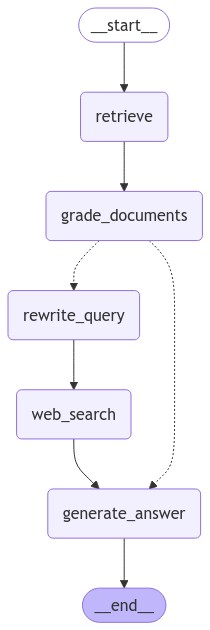

In [105]:
from IPython.display import Image, display, Markdown

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

### Test the Agentic CRAG System

In [108]:
query = "What attention mechanisms were used in the Attention paper?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


In [109]:
display(Markdown(response['generation']))

The Attention paper, specifically the Transformer model, utilizes two main attention mechanisms: Scaled Dot-Product Attention and Multi-Head Attention.

1. **Scaled Dot-Product Attention**: This mechanism involves computing the dot products of the query with all keys, dividing each by the square root of the dimension of the keys (\(\sqrt{d_k}\)), and applying a softmax function to obtain the weights on the values. This scaling factor is used to counteract the effect of large dot products, which can push the softmax function into regions with extremely small gradients.

2. **Multi-Head Attention**: This mechanism involves running several attention layers, or "heads," in parallel. Each head performs the attention function on different linear projections of the queries, keys, and values. The outputs of these heads are then concatenated and projected to form the final output. Multi-head attention allows the model to attend to information from different representation subspaces at different positions, enhancing the model's ability to capture various aspects of the input data.

These mechanisms are employed in different ways within the Transformer model, such as in encoder-decoder attention layers, encoder self-attention layers, and decoder self-attention layers, each serving specific roles in processing the input and output sequences.

In [110]:
response

{'question': 'What attention mechanisms were used in the Attention paper?',
 'generation': 'The Attention paper, specifically the Transformer model, utilizes two main attention mechanisms: Scaled Dot-Product Attention and Multi-Head Attention.\n\n1. **Scaled Dot-Product Attention**: This mechanism involves computing the dot products of the query with all keys, dividing each by the square root of the dimension of the keys (\\(\\sqrt{d_k}\\)), and applying a softmax function to obtain the weights on the values. This scaling factor is used to counteract the effect of large dot products, which can push the softmax function into regions with extremely small gradients.\n\n2. **Multi-Head Attention**: This mechanism involves running several attention layers, or "heads," in parallel. Each head performs the attention function on different linear projections of the queries, keys, and values. The outputs of these heads are then concatenated and projected to form the final output. Multi-head atten

In [111]:
query = "What novel approaches did the Gemini paper introduce in LLM training?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---


In [112]:
display(Markdown(response['generation']))

The Gemini paper introduced several novel approaches in the training of large language models (LLMs):

1. **Multimodal Training**: The Gemini models are natively multimodal, meaning they are trained jointly across text, image, audio, and video. This approach allows the models to achieve strong capabilities in each domain, setting a new state of the art across a wide range of benchmarks.

2. **Tokenization and Training Strategy**: The number of tokens used to train the largest models was determined following the approach in Hoffmann et al. (2022), while smaller models were trained with significantly more tokens to improve performance for a given inference budget, similar to the approach in Touvron et al. (2023a).

3. **Data Quality and Filtering**: The paper emphasizes the importance of data quality for high-performing models. Quality filters, both heuristic and model-based, were applied to all datasets. Safety filtering was also performed to remove harmful content. The final data mixtures and weights were determined through ablations on smaller models, and training was staged to alter the mixture composition, increasing the weight of domain-relevant data towards the end of training.

4. **Tool Use**: By training LLMs to use tools, the capabilities of the models were greatly expanded beyond their internal knowledge. Tool use was treated as a code generation problem, leveraging the model's strong coding capabilities. This approach allows the model to compose multiple tools in each code block and react to the results of tool execution.

These approaches collectively contribute to the enhanced performance and capabilities of the Gemini models in various domains.

In [106]:
query = "What datasets were used for training in the GPT-4 paper?"
response = agentic_rag.invoke({"question": query})

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---NO DOCUMENTS RETRIEVED---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---WEB SEARCH RESULTS---
In this study, we hypothesized that ChatGPT can compose text, tables and figures for a biomedical research paper using two cancer research papers as benchmarks. To test this ... eleven reference articles were utilized to construct ... despite the possibility that the original review paper BRP1 was part of GPT-4's training dataset, the
Treatment recommendations were elicited from GPT-4 and evaluated by two board-certified specialty-trained senior orthopedic surgeons. ... and domain-specific training using medical datasets
We systematically assessed GPT-4's cell type annotation performance across ten datasets 4,5,6,7,8,9,10,11,12, covering five species and hundreds of tissue and cell types, and including both
---GEN

In [107]:
display(Markdown(response['generation']))

The provided context does not specify the exact datasets used for training in the GPT-4 research paper. It mentions the use of medical datasets for domain-specific training and the assessment of GPT-4's performance across ten datasets covering various species and cell types, but it does not detail the specific datasets used for the overall training of GPT-4. Therefore, I don't know the answer based on the given context.